# Not my work - just my updates

This example was originally [here from machinalis](http://nbviewer.jupyter.org/github/abarto/embedding_interactive_maps_into_an_ipython_notebook/blob/master/embedding_interactive_maps_to_ipython_notebook.ipynb) 
but needed a good bit of updating for the new IPython notebooks interface and Python 3.

Environment
See the req.txt, but in particular
```bash
conda install basemap matplotlib 
```



In [22]:
%matplotlib inline

import jinja2
import json
import requests

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import OrderedDict
from datetime import datetime
from dateutil import parser
from io import StringIO
from io import BytesIO

In [64]:
#from IPython.html.widgets import interact
#from IPython.html import widgets
from IPython.display import display
from IPython.display import Javascript
import ipywidgets as widgets
from ipywidgets import interact

In [4]:
#from IPython.display import display, display_pretty, Javascript, HTML
from mpl_toolkits.basemap import Basemap
from xml.etree import ElementTree

In [9]:
from traitlets import Unicode

In [10]:
%%javascript
require.config({
    paths: {
        async: '//cdnjs.cloudflare.com/ajax/libs/requirejs-async/0.1.1/async',
        open_layers: '//cdnjs.cloudflare.com/ajax/libs/openlayers/2.13.1/OpenLayers'
    }
});

<IPython.core.display.Javascript object>

# Adding Interactive Maps to an IPython Notebook

## Introduction

There are many sources of geolocated data for interesting events available on the Internet. The data ranges from catastrophic events as the latest earthquakes, to the most mundane of tweets regarding Kim Kardashian. Putting aside the actual value of the data, IPyhton Notebooks are a great tool to play, analyze and publish the results of of our work.

The purpose of this post (and the associated Notebook) is to show you how easy it is to fetch geolocated data from public sources, create Pandas' DataFrames from it, and plotting the results using interactive Matplotlib, Google Maps and OpenLayers.

## Requirements

In order to properly run this Notebook, you need to install the following Python modules:

* matplotlib
* Basemap (you might need to install it with pip install basemap --allow-external basemap --allow-unverified basemap)
* dateutil
* pandas

The rest of the modules we use are dependencies for IPython Notebook, pandas or Basemap.

## About Pandas

Although Pandas is not strictly necessary to accomplish what we do in the examples, it is such a popular data analysis tool that we wanted to use it anyway. We recommend that you read the [10 Minutes to Pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html#min) tutorial to get and idea of what it can do or buy [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) for an in depth guide of data analysis using Python, Pandas and NumPy.

## Custom date picker widget

Before we can show you how to embed interactive maps we need to define a custom IPython Notebook widget to pick dates. The code is pretty much the same as the one presented in [this example](http://nbviewer.ipython.org/github/ipython/ipython/blob/master/examples/Interactive%20Widgets/Custom%20Widgets.ipynb) save for a few bugfixes.

In [13]:
# Taken from http://nbviewer.ipython.org/github/ipython/ipython/blob/master/examples/Interactive%20Widgets/Custom%20Widgets.ipynb

class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView')
    value = Unicode()
    description = Unicode()
    _view_name.tag(sync=True)
    value.tag(sync=True)
    description.tag(sync=True)
    
    # This function automatically gets called by the traitlet machinery when
    # value is modified because of this function's name.
    def _value_changed(self, name, old_value, new_value):
        # Parse the date time value.
        try:
            parsed_date = parser.parse(new_value)
            parsed_date_string = parsed_date.strftime("%Y-%m-%d")
        except:
            parsed_date_string = ''
        
        # Set the parsed date string if the current date string is different.
        if self.value != parsed_date_string:
            self.value = parsed_date_string

In [14]:
%%javascript

// Taken from http://nbviewer.ipython.org/github/ipython/ipython/blob/master/examples/Interactive%20Widgets/Custom%20Widgets.ipynb

require(["widgets/js/widget"], function(WidgetManager){
    
    // Define the DatePickerView
    var DatePickerView = IPython.DOMWidgetView.extend({
        render: function(){
            this.$el.addClass('widget-hbox-single'); /* Apply this class to the widget container to make
                                                        it fit with the other built in widgets.*/
            // Create a label.
            this.$label = $('<div />')
                .addClass('widget-hlabel')
                .appendTo(this.$el)
                .hide(); // Hide the label by default.
            
            // Create the date picker control.
            this.$date = $('<input />')
                .attr('type', 'date')
                .appendTo(this.$el);
            
            // FIXED: This line wasn't on the example, but the widget is not properly initialized if we
            // don't call update() on render()
            this.update();
        },
        
        update: function() {
            console.log('value', this.model.get('value'))
            
            // Set the value of the date control and then call base.
            this.$date.val(this.model.get('value')); // ISO format "YYYY-MM-DDTHH:mm:ss.sssZ" is required
            
            // Hide or show the label depending on the existance of a description.
            var description = this.model.get('description');
            if (description == undefined || description == '') {
                this.$label.hide();
            } else {
                this.$label.show();
                this.$label.text(description);
            }
            
            return DatePickerView.__super__.update.apply(this);
        },
        
        // Tell Backbone to listen to the change event of input controls (which the HTML date picker is)
        events: {"change": "handle_date_change"},
        
        // Callback for when the date is changed.
        handle_date_change: function(event) {
            this.model.set('value', this.$date.val());
            this.touch();
        },
    });
    
    // Register the DatePickerView with the widget manager.
    WidgetManager.register_widget_view('DatePickerView', DatePickerView);
});

<IPython.core.display.Javascript object>

## Plotting historic earthquake data for Mexico City with Matplotlib

The [United States Geological Survey](http://www.usgs.gov/) is a fantastic source of information. They provide quality data from all over the planet in a variety of formats for all kinds of events (not just geological ones), so it's the go to source for [examples](http://maps.google.com/gallery/details?id=z4f-ZuCLmiKg.kjEKRL8AzeQM&hl=en) [related](http://nbviewer.ipython.org/github/ehmatthes/intro_programming/blob/master/notebooks/visualization_earthquakes.ipynb) to geolocated data.

For this example we're going to use [Earthquake Search and Web Service API](http://comcat.cr.usgs.gov/fdsnws/event/1/) that allows you to search for geological events using several criteria and filters.

We're going to plot (initially) all the earthquakes of magnitude 4.0 or higher in an 800km circle around Mexico City from 1/1/1984 to 1/1/2014.

In order to make the map interactive, we'll use IPython's [interact()](http://nbviewer.ipython.org/github/ipython/ipython/blob/2.x/examples/Interactive%20Widgets/Using%20Interact.ipynb) function that takes a callback function and an arbitrary list of parameters that can either be fixed values or widgets. Whenever a widget is updated, the callback function is called.

Our callback function display_map, makes a request to the USGS API, creates a Pandas DataFrame from the CSV response, creates a Basemap map, and plots the geological events onto the map. The latitude, longitude, radius, start date, end date and minimum magnitude parameters are presented as widgets. The start date and end date use the custom date selection widget that was defined above.

In [50]:
def display_map(latitude, longitude, starttime, endtime, maxradiuskm, minmagnitude):
    # Make the request to the Earthquake Search and Web Service API 
    #response = requests.get('http://comcat.cr.usgs.gov/fdsnws/event/1/query', params={
    response = requests.get('http://earthquake.usgs.gov/fdsnws/event/1/query', params={
        'starttime': parser.parse(starttime).isoformat(),
        'endtime': parser.parse(endtime).isoformat(),
        'latitude': latitude,
        'longitude': longitude,
        'maxradiuskm': maxradiuskm,
        'minmagnitude': minmagnitude,
        'magtype': 'mb_lg', # Request local  magnitude
        'format': 'csv' # We ask for a CSV formatted response
    })
    
    # Create a DataFrame from the CSV response. Notice that we force Pandas to
    # interpret the latitude and longitude columns as float and that we use the
    # time column as index.
    #print("display_map::Response Text:: \n", response.text)
    earthquakes_df = pd.read_csv(
        #StringIO.StringIO(response.text),
        StringIO(response.text),
        dtype={'latitude':'float', 'longitude':'float'},
        index_col='time',
        parse_dates=True
    )

    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

    # Create a new map with cylindrical projection centered around the supplied
    # coordinates
    m = Basemap(
                ax=axes,
                projection='cyl',
                lon_0=longitude, lat_0=latitude,
                llcrnrlat=latitude - 5.0, urcrnrlat=latitude + 5.0,
                llcrnrlon=longitude - 5.0, urcrnrlon=longitude + 5.0,
                resolution='i'
                )

    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='coral',lake_color='aqua')
    
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawstates()

    # Plot the geolocical events as blue dots
    x, y = m(earthquakes_df.longitude, earthquakes_df.latitude)
    m.plot(x, y, 'bo', alpha=0.5)

    x, y = m([longitude], [latitude])
    m.plot(x, y, 'rx', markersize=15.0)

    plt.title('Earthquakes around ({longitude}, {latitude}) from {starttime} to {endtime}'.format(longitude=longitude, latitude=latitude, starttime=starttime, endtime=endtime))
    plt.show()

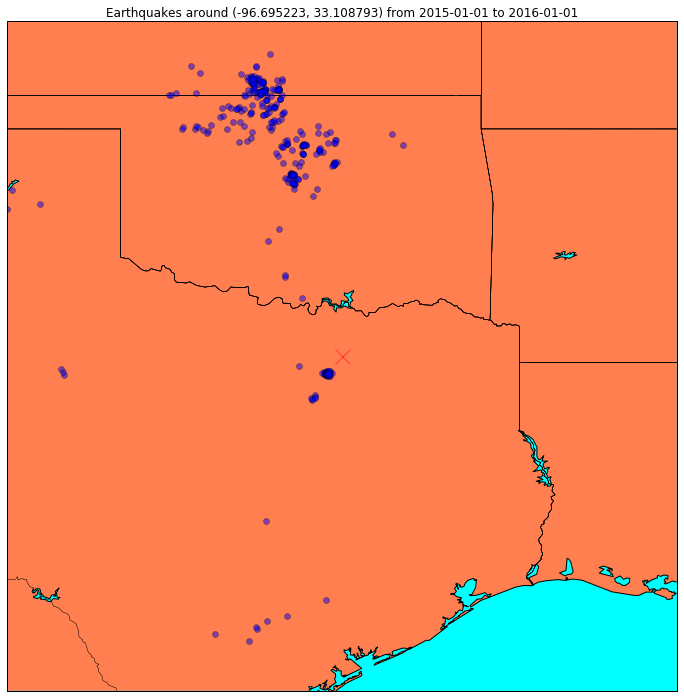

In [51]:
i = interact(
    display_map,
    latitude=widgets.FloatText(value=33.108793, min=-90.0, max=90.0),
    longitude=widgets.FloatText(value=-96.695223, min=-180.0, max=180.0),
    starttime=DateWidget(value='2015-01-01'),
    endtime=DateWidget(value='2016-01-01'),
    maxradiuskm=widgets.FloatText(value=600, min=0.0),
    minmagnitude=widgets.FloatText(value=2.0, min=0.0)
)

## Plotting recent earthquakes with Google Maps

Although Basemap is quite capable it lacks the interactivity that most users are accostumed to. Luckily, it is pretty simple to embed arbitrary HTML and Javascript code into an IPython Notebook, and we're going to use this feature to integrate Google Maps (using [Google Maps Javascript API](https://developers.google.com/maps/documentation/javascript/)) in our example.

We'll use of one USGS [earthquake feeds](http://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php) to plot the latest events. We're going to use the interact function() again, but we'll give the user the ability to choose which feed to use and the type of map to render. Notice that there's an additional parameter called "div" that takes and HTMLWidget as parameter. We need this widget rendered before any Javascript code is executed so the Google Maps API can paint the map onto it.

The callback function makes the request to the web service, and generates a Pandas DataFrame from the JSON response. Afterwards it  displays Javascript code from a Jinja2 template that creates the map, and then iterates over the events to create a marker for each of them. 

In [52]:
def display_earthquake_markers_map(latitude, longitude, feed, map_type, div):
    # Make a request to the supplied feed and parse the response as JSON
    response = requests.get(feed)
    response_json = response.json()
    
    # Create a DataFrame from a list comprehension built from the "features"
    # field of the JSON response.
    latest_earthquakes = [(
        datetime.fromtimestamp(float(feature['properties']['time']) / 1000.0),
        feature['geometry']['coordinates'][1],
        feature['geometry']['coordinates'][0],
        feature['properties']['mag'],
        feature['properties']['title'],
    ) for feature in response_json['features']]
    
    latest_earthquakes_df = pd.DataFrame(latest_earthquakes, columns=['time', 'latitude', 'longitude', 'mag', 'title'])
    latest_earthquakes_df.set_index('time', inplace=True)
    
    # Define a Jinja2 template that creates the map, and iterates of the
    # features to create a marker for each of them.
    latest_earthquakes_javascript = jinja2.Template(
    """
    require(['async!http://maps.googleapis.com/maps/api/js?sensor=false&libraries=visualization&callback=console.log'], function() {
        var mapOptions = {
            zoom: 2.0,
            center: new google.maps.LatLng({{ latitude }}, {{ longitude }}),
            mapTypeId: {{ map_type }}
        };

        var map = new google.maps.Map(document.getElementById('latest_earthquakes_map_markers'), mapOptions);
        var markers = Array();
    
        var machinalis_marker = new google.maps.Marker({
            position: new google.maps.LatLng(-31.4122599,-64.2010031),
            icon: {
                size: new google.maps.Size(30, 30),
                url: 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAB4AAAAeCAYAAAA7MK6iAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAB3RJTUUH3gUdESIC2is5hgAAAB1pVFh0Q29tbWVudAAAAAAAQ3JlYXRlZCB3aXRoIEdJTVBkLmUHAAAF9klEQVRIx72WaVBTVxTH/29LYgCxskQkLlSgSFSMYqmgVRSjIoxUpVrHqrWiWMcFl7rUDrU6Mu1UaV1ah6mOSGHccBxrnSq4VS1QQcRQjIIgiAUEFRASs7x3+yESQxIRmE7vpzfv3nt+95zzP+deoBujMHbDyjyXcJLLhRF1WFxVUKCC6aoNujtg44073xG9AaAptObf6bdBOlj5v4BB220j/zn4aMTCThkqW7TN8p2lWvLG9eybFszOPoSLk+PneurI96VyacAHGclPHa3zPfglyhZtO1L74KHrmPMpUzvt8TpXhd3keP8hLjcDPix2unYnvSWn2IPTGvp0ZExbVj2BuaKeku8dpS349KulnQJv3vJFv0ynkHX3P/t2FACkKqcHJlOBzfqyagUx8QBNARTVYS4pmjZSNA1TQ2MPY+r5/fkRy1YDwG9LtsjOeIQvvTAsdjIAJPmHvwq1Zmfqr95GLqj+wGkURq46T0qrw/VV/4Biuqc/MDRMl24lF83ZFG04lR/ONxkpmmpGkn84t+neJRMNAJkTFkYxrYYgUOY9+qx8laGylrMYEQjY3j1hchY3dsTiPHrVEkGwUhADXeaVCXxjCwUKEJ49h8pzkNoSapahtbSIA9o2mcNqgdKyt1pefDJpcEzazprXQZtX7UHA8aSRxM/7D7vSo8wFR7EMOIm4wQKennXwYtFQd4VkuH+Tnex794Ru4UTlmB0Jmo687fnDCgBAqObEOOfRQ0vsIu/qBFHs+MRh2fvGthPX4ssZJS5BfhG2GwR/73XjtieUdTa1pQu24oVvn2lEaK/DZi/XA8rD27522ECqLuQEt1Mpx0IX+s4vu5VRndaUX2oign9OfCCdFFwIq3w7CdT8dpG8MWNtnFBcsRsA6GYdx1sJShoSWBXyzfo6O+vWAnp5Rtsf1yrvJo2SiI8JBqN5QUUtdyNglk4QBFByz2ssybqZQvQGAAAPysoEgUjued1hvfaXPUJV/UBQAOvmihYJ1WCXUxfpaUpCgJdgYuLBl9dIAIBUPo5ghRfmW8ZxfbB25VM9dyvkGYk+l2clLAdPJOWc4eySYz8+sFN5D1ZvZ7etUggBK1X612mLSmWOuPyz58Nt/8kzEs3t9ETyvg5V3qwfBiPv+ILw6GVi97o09JuslI8w8bxxQCvicL8mvu102rySYHRzKOQDlvHqAouXEp++KB/QU0GaWpy1Ura2XSzygj9WEXXFuVe3LAGJUE4cfXbvxc4CT0XFg14zQySP2681PKxj2sCtPp45EzUnQx2WE9PXbYptTqTPdOld8TTmzH64f354gaH6sQUKAJ4eHrLEoRNk7cApo2d6F/jOqDedy0+wNaTLv9MnJ2jOGQC4t3j7a4Gno8wZuh67fjZXXpdiO9+So347qoarLfloc5IFLGOlK0xVde7WIbbutfTdR9PU4cuuNfagvayN7QpUWb41q6ewuaMXxosu3DrCt+pga4tiaPDNLTDcrlhvpW/gr76RrcKTZikAcHIPo+FhPUfZVgPLQqwKzr6iKdrxgqOvbrh9zrQrUDUoOEAR51JcvUZfWcO1bzQEIm8P3lDTwJjhDO4rvebPvX4k7RVYtXy+UNNwsMmg31gTM+KnIXnVCaar6m1gGbuuRTv1AC0RARQFYuTBP281e2Z9UkJg7OdedjXSb+TMevHwJ+p76bSztOi9vNSojLA5cNg5dgZEYK0mGwWRK4uNWfkKB6/KjgcBmF7OpHJeaB9xYXl99KVD5I09tm2cmbt2oOfZWxWCTt/dUoYwZMDs0IL0Y1163nrerVtkgRICTtYbpsD+JxgfL1A2yRfLZTD6epVQwwf9bi1MsdZ4tMvv6kadVsO4OJlvIoaBJDp0/pjCjNhRmuMU3dfNaA24O8Tdf+zfxxUhealTaTfXVggCKJoGLxXf7DJYVXIyI7e/yJULDngkCVVkK/ZtTHulm/YpM9U+dbb06JixCU4jAwzVo/qvebcgbWSX87NnRPRr5wrGL/0zVzKW5IrCSMHAGENKWKzc0brM9+e91sa/SYtOrUfMruYAAAAASUVORK5CYII='
            },
            title: 'http://www.machinalis.com',
            map: map
        });

        {% for earthquake in latest_earthquakes %}
        markers.push(new google.maps.Marker({
            position: new google.maps.LatLng({{ earthquake[1] }}, {{ earthquake[2] }}),
            title: "{{ earthquake[4] }}",
            map: map
        }));
        {% endfor %}
    });    
    """
    )
    
    # Render the template and display it as Javascript
    display(Javascript(latest_earthquakes_javascript.render(
        latest_earthquakes=latest_earthquakes_df.itertuples(),
        map_type=map_type, latitude=latitude, longitude=longitude
    )))

In [57]:
?widgets.Dropdown()

In [66]:
i = interact(
    display_earthquake_markers_map,
    latitude=widgets.FloatText(value=-31.4122599, min=-90.0, max=90.0),
    longitude=widgets.FloatText(value=-64.2010031, min=-180.0, max=180.0),
    map_type=widgets.Dropdown(options={
        'Road Map': 'google.maps.MapTypeId.ROADMAP',
        'Satellite': 'google.maps.MapTypeId.SATELLITE',
        'Hybrid': 'google.maps.MapTypeId.HYBRID',
        'Terrain': 'google.maps.MapTypeId.TERRAIN',
    }, value='google.maps.MapTypeId.SATELLITE'),
    feed=widgets.Dropdown(options={
        'Significant Earthquakes': 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/significant_week.geojson',
        'M4.5+ Earthquakes': 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_week.geojson',
        'M2.5+ Earthquakes': 'hytp://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson',
        'M1.0+ Earthquakes': 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/1.0_week.geojson',
        'All Earthquakes': 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_week.geojson'
    }, value='http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_week.geojson'),
    div=widgets.HTML(value='<div id="latest_earthquakes_map_markers" style="width: 800px; height: 600px"></div>')
)

<IPython.core.display.Javascript object>

It might be useful to represent the geological events as circles with radius proportional to its magnitude. For that we define a getCircle Javascript function that's going to define the icon for each marker.

In [67]:
def display_earthquake_circles_map(latitude, longitude, feed, map_type, div):
    response = requests.get(feed)
    response_json = response.json()
    
    latest_earthquakes = [(
        datetime.fromtimestamp(float(feature['properties']['time']) / 1000.0),
        feature['geometry']['coordinates'][1],
        feature['geometry']['coordinates'][0],
        feature['properties']['mag'],
        feature['properties']['title'],
    ) for feature in response_json['features']]
    
    latest_earthquakes_df = pd.DataFrame(latest_earthquakes, columns=['time', 'latitude', 'longitude', 'mag', 'title'])
    latest_earthquakes_df.set_index('time', inplace=True)
    
    latest_earthquakes_javascript = jinja2.Template(
    """
    require(['async!http://maps.googleapis.com/maps/api/js?sensor=false&libraries=visualization&callback=console.log'], function() {
        function getCircle(magnitude) {
            return {
                path: google.maps.SymbolPath.CIRCLE,
                fillColor: 'red',
                fillOpacity: .2,
                scale: Math.pow(2, magnitude) / Math.PI,
                strokeColor: 'white',
                strokeWeight: .5
            };
        }

        var mapOptions = {
            zoom: 2.0,
            center: new google.maps.LatLng({{ latitude }}, {{ longitude }}),
            mapTypeId: {{ map_type }}
        };

        var map = new google.maps.Map(document.getElementById('latest_earthquakes_map_circles'), mapOptions);

        var machinalis_marker = new google.maps.Marker({
            position: new google.maps.LatLng(-31.4122599,-64.2010031),
            icon: {
                size: new google.maps.Size(30, 30),
                url: 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAB4AAAAeCAYAAAA7MK6iAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAB3RJTUUH3gUdESIC2is5hgAAAB1pVFh0Q29tbWVudAAAAAAAQ3JlYXRlZCB3aXRoIEdJTVBkLmUHAAAF9klEQVRIx72WaVBTVxTH/29LYgCxskQkLlSgSFSMYqmgVRSjIoxUpVrHqrWiWMcFl7rUDrU6Mu1UaV1ah6mOSGHccBxrnSq4VS1QQcRQjIIgiAUEFRASs7x3+yESQxIRmE7vpzfv3nt+95zzP+deoBujMHbDyjyXcJLLhRF1WFxVUKCC6aoNujtg44073xG9AaAptObf6bdBOlj5v4BB220j/zn4aMTCThkqW7TN8p2lWvLG9eybFszOPoSLk+PneurI96VyacAHGclPHa3zPfglyhZtO1L74KHrmPMpUzvt8TpXhd3keP8hLjcDPix2unYnvSWn2IPTGvp0ZExbVj2BuaKeku8dpS349KulnQJv3vJFv0ynkHX3P/t2FACkKqcHJlOBzfqyagUx8QBNARTVYS4pmjZSNA1TQ2MPY+r5/fkRy1YDwG9LtsjOeIQvvTAsdjIAJPmHvwq1Zmfqr95GLqj+wGkURq46T0qrw/VV/4Biuqc/MDRMl24lF83ZFG04lR/ONxkpmmpGkn84t+neJRMNAJkTFkYxrYYgUOY9+qx8laGylrMYEQjY3j1hchY3dsTiPHrVEkGwUhADXeaVCXxjCwUKEJ49h8pzkNoSapahtbSIA9o2mcNqgdKyt1pefDJpcEzazprXQZtX7UHA8aSRxM/7D7vSo8wFR7EMOIm4wQKennXwYtFQd4VkuH+Tnex794Ru4UTlmB0Jmo687fnDCgBAqObEOOfRQ0vsIu/qBFHs+MRh2fvGthPX4ssZJS5BfhG2GwR/73XjtieUdTa1pQu24oVvn2lEaK/DZi/XA8rD27522ECqLuQEt1Mpx0IX+s4vu5VRndaUX2oign9OfCCdFFwIq3w7CdT8dpG8MWNtnFBcsRsA6GYdx1sJShoSWBXyzfo6O+vWAnp5Rtsf1yrvJo2SiI8JBqN5QUUtdyNglk4QBFByz2ssybqZQvQGAAAPysoEgUjued1hvfaXPUJV/UBQAOvmihYJ1WCXUxfpaUpCgJdgYuLBl9dIAIBUPo5ghRfmW8ZxfbB25VM9dyvkGYk+l2clLAdPJOWc4eySYz8+sFN5D1ZvZ7etUggBK1X612mLSmWOuPyz58Nt/8kzEs3t9ETyvg5V3qwfBiPv+ILw6GVi97o09JuslI8w8bxxQCvicL8mvu102rySYHRzKOQDlvHqAouXEp++KB/QU0GaWpy1Ura2XSzygj9WEXXFuVe3LAGJUE4cfXbvxc4CT0XFg14zQySP2681PKxj2sCtPp45EzUnQx2WE9PXbYptTqTPdOld8TTmzH64f354gaH6sQUKAJ4eHrLEoRNk7cApo2d6F/jOqDedy0+wNaTLv9MnJ2jOGQC4t3j7a4Gno8wZuh67fjZXXpdiO9+So347qoarLfloc5IFLGOlK0xVde7WIbbutfTdR9PU4cuuNfagvayN7QpUWb41q6ewuaMXxosu3DrCt+pga4tiaPDNLTDcrlhvpW/gr76RrcKTZikAcHIPo+FhPUfZVgPLQqwKzr6iKdrxgqOvbrh9zrQrUDUoOEAR51JcvUZfWcO1bzQEIm8P3lDTwJjhDO4rvebPvX4k7RVYtXy+UNNwsMmg31gTM+KnIXnVCaar6m1gGbuuRTv1AC0RARQFYuTBP281e2Z9UkJg7OdedjXSb+TMevHwJ+p76bSztOi9vNSojLA5cNg5dgZEYK0mGwWRK4uNWfkKB6/KjgcBmF7OpHJeaB9xYXl99KVD5I09tm2cmbt2oOfZWxWCTt/dUoYwZMDs0IL0Y1163nrerVtkgRICTtYbpsD+JxgfL1A2yRfLZTD6epVQwwf9bi1MsdZ4tMvv6kadVsO4OJlvIoaBJDp0/pjCjNhRmuMU3dfNaA24O8Tdf+zfxxUhealTaTfXVggCKJoGLxXf7DJYVXIyI7e/yJULDngkCVVkK/ZtTHulm/YpM9U+dbb06JixCU4jAwzVo/qvebcgbWSX87NnRPRr5wrGL/0zVzKW5IrCSMHAGENKWKzc0brM9+e91sa/SYtOrUfMruYAAAAASUVORK5CYII='
            },
            title: 'http://www.machinalis.com',
            map: map
        });

        var markers = Array();

        {% for earthquake in latest_earthquakes %}
        markers.push(new google.maps.Marker({
            position: new google.maps.LatLng({{ earthquake[1] }}, {{ earthquake[2] }}),
            title: "{{ earthquake[4] }}",
            icon: getCircle({{ earthquake[3] }}),
            map: map
        }));
        {% endfor %}
    });
    """
    )
    display(Javascript(latest_earthquakes_javascript.render(
        latest_earthquakes=latest_earthquakes_df.itertuples(),
        map_type=map_type, latitude=latitude, longitude=longitude
    )))

In [69]:
i = interact(
    display_earthquake_circles_map,
    latitude=widgets.FloatText(value=-31.4122599, min=-90.0, max=90.0),
    longitude=widgets.FloatText(value=-64.2010031, min=-180.0, max=180.0),
    map_type = widgets.Dropdown(options={
        'Road Map': 'google.maps.MapTypeId.ROADMAP',
        'Satellite': 'google.maps.MapTypeId.SATELLITE',
        'Hybrid': 'google.maps.MapTypeId.HYBRID',
        'Terrain': 'google.maps.MapTypeId.TERRAIN',
    }, value='google.maps.MapTypeId.SATELLITE'),
    feed = widgets.Dropdown(options={
        'Significant Earthquakes': 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/significant_week.geojson',
        'M4.5+ Earthquakes': 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_week.geojson',
        'M2.5+ Earthquakes': 'hytp://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson',
        'M1.0+ Earthquakes': 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/1.0_week.geojson',
        'All Earthquakes': 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_week.geojson'
    }, value='http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_week.geojson'),
    div=widgets.HTML(value='<div id="latest_earthquakes_map_circles" style="width: 800px; height: 600px"></div>')
)

<IPython.core.display.Javascript object>

## Plotting recent heat points in Argentina with Google Maps 

We mentioned at the beginning of the post that there are many sources of geolocated data available on the Internet. Of one such sources is provided by [CONAE](http://www.conae.gov.ar/index.php/espanol/) (The Argentine Space Agency) and it gives us a list of [heat points](http://catalogos.conae.gov.ar/focos/) as a GEORSS feed (A specialized Atom feed).

We can use this feed to build a new DataFrame and from it, a map that shows those heat points with a custom icon (an Base64 encoded PNG file). As before, we're going to use requests to fetch the data, but this time we'll use ElementTree and XPath to parse and preparte the date before we build the DataFrame. All this functionality is contained within a new callback function.

In [70]:
def display_heat_points_map(latitude, longitude, map_type, div):
    # Make the request and parse the response as XML using ElementTree
    response = requests.get('http://catalogos.conae.gov.ar/focos/focosdecalor.xml')
    response_atom = ElementTree.parse(BytesIO(response.content))

    # Build a DataFrame extrating the data for each entry using XPath
    entries_id = [e.text for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.w3.org/2005/Atom}id')]
    entries_title = [e.text for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.w3.org/2005/Atom}title')]
    entries_updated = [e.text for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.w3.org/2005/Atom}updated')]
    entries_summary = [e.text for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.w3.org/2005/Atom}summary')]
    entries_point_lat = [float(e.text.split(" ")[0]) for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.georss.org/georss}point')]
    entries_point_lon = [float(e.text.split(" ")[1]) for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.georss.org/georss}point')]

    entries_df = pd.DataFrame({
        'id': entries_id,
        'title': entries_title,
        'summary': entries_summary,
        'lat': entries_point_lat,
        'lon': entries_point_lon
    }, index=entries_updated)

    # Define a Jinja2 template that creates the map, and iterates of the
    # entries to create a marker with a custom icon for each of them.
    heat_points_javascript = jinja2.Template(
    """
    require(['async!http://maps.googleapis.com/maps/api/js?sensor=false&libraries=visualization&callback=console.log'], function() {
        var mapOptions = {
            zoom: 4,
            center: new google.maps.LatLng({{ latitude }}, {{ longitude }}),
            mapTypeId: {{ map_type }}
        };

        var map = new google.maps.Map(document.getElementById('heat_points'), mapOptions);

        var machinalis_marker = new google.maps.Marker({
            position: new google.maps.LatLng(-31.4122599,-64.2010031),
            icon: {
                size: new google.maps.Size(30, 30),
                url: 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAB4AAAAeCAYAAAA7MK6iAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAB3RJTUUH3gUdESIC2is5hgAAAB1pVFh0Q29tbWVudAAAAAAAQ3JlYXRlZCB3aXRoIEdJTVBkLmUHAAAF9klEQVRIx72WaVBTVxTH/29LYgCxskQkLlSgSFSMYqmgVRSjIoxUpVrHqrWiWMcFl7rUDrU6Mu1UaV1ah6mOSGHccBxrnSq4VS1QQcRQjIIgiAUEFRASs7x3+yESQxIRmE7vpzfv3nt+95zzP+deoBujMHbDyjyXcJLLhRF1WFxVUKCC6aoNujtg44073xG9AaAptObf6bdBOlj5v4BB220j/zn4aMTCThkqW7TN8p2lWvLG9eybFszOPoSLk+PneurI96VyacAHGclPHa3zPfglyhZtO1L74KHrmPMpUzvt8TpXhd3keP8hLjcDPix2unYnvSWn2IPTGvp0ZExbVj2BuaKeku8dpS349KulnQJv3vJFv0ynkHX3P/t2FACkKqcHJlOBzfqyagUx8QBNARTVYS4pmjZSNA1TQ2MPY+r5/fkRy1YDwG9LtsjOeIQvvTAsdjIAJPmHvwq1Zmfqr95GLqj+wGkURq46T0qrw/VV/4Biuqc/MDRMl24lF83ZFG04lR/ONxkpmmpGkn84t+neJRMNAJkTFkYxrYYgUOY9+qx8laGylrMYEQjY3j1hchY3dsTiPHrVEkGwUhADXeaVCXxjCwUKEJ49h8pzkNoSapahtbSIA9o2mcNqgdKyt1pefDJpcEzazprXQZtX7UHA8aSRxM/7D7vSo8wFR7EMOIm4wQKennXwYtFQd4VkuH+Tnex794Ru4UTlmB0Jmo687fnDCgBAqObEOOfRQ0vsIu/qBFHs+MRh2fvGthPX4ssZJS5BfhG2GwR/73XjtieUdTa1pQu24oVvn2lEaK/DZi/XA8rD27522ECqLuQEt1Mpx0IX+s4vu5VRndaUX2oign9OfCCdFFwIq3w7CdT8dpG8MWNtnFBcsRsA6GYdx1sJShoSWBXyzfo6O+vWAnp5Rtsf1yrvJo2SiI8JBqN5QUUtdyNglk4QBFByz2ssybqZQvQGAAAPysoEgUjued1hvfaXPUJV/UBQAOvmihYJ1WCXUxfpaUpCgJdgYuLBl9dIAIBUPo5ghRfmW8ZxfbB25VM9dyvkGYk+l2clLAdPJOWc4eySYz8+sFN5D1ZvZ7etUggBK1X612mLSmWOuPyz58Nt/8kzEs3t9ETyvg5V3qwfBiPv+ILw6GVi97o09JuslI8w8bxxQCvicL8mvu102rySYHRzKOQDlvHqAouXEp++KB/QU0GaWpy1Ura2XSzygj9WEXXFuVe3LAGJUE4cfXbvxc4CT0XFg14zQySP2681PKxj2sCtPp45EzUnQx2WE9PXbYptTqTPdOld8TTmzH64f354gaH6sQUKAJ4eHrLEoRNk7cApo2d6F/jOqDedy0+wNaTLv9MnJ2jOGQC4t3j7a4Gno8wZuh67fjZXXpdiO9+So347qoarLfloc5IFLGOlK0xVde7WIbbutfTdR9PU4cuuNfagvayN7QpUWb41q6ewuaMXxosu3DrCt+pga4tiaPDNLTDcrlhvpW/gr76RrcKTZikAcHIPo+FhPUfZVgPLQqwKzr6iKdrxgqOvbrh9zrQrUDUoOEAR51JcvUZfWcO1bzQEIm8P3lDTwJjhDO4rvebPvX4k7RVYtXy+UNNwsMmg31gTM+KnIXnVCaar6m1gGbuuRTv1AC0RARQFYuTBP281e2Z9UkJg7OdedjXSb+TMevHwJ+p76bSztOi9vNSojLA5cNg5dgZEYK0mGwWRK4uNWfkKB6/KjgcBmF7OpHJeaB9xYXl99KVD5I09tm2cmbt2oOfZWxWCTt/dUoYwZMDs0IL0Y1163nrerVtkgRICTtYbpsD+JxgfL1A2yRfLZTD6epVQwwf9bi1MsdZ4tMvv6kadVsO4OJlvIoaBJDp0/pjCjNhRmuMU3dfNaA24O8Tdf+zfxxUhealTaTfXVggCKJoGLxXf7DJYVXIyI7e/yJULDngkCVVkK/ZtTHulm/YpM9U+dbb06JixCU4jAwzVo/qvebcgbWSX87NnRPRr5wrGL/0zVzKW5IrCSMHAGENKWKzc0brM9+e91sa/SYtOrUfMruYAAAAASUVORK5CYII='
            },
            title: 'http://www.machinalis.com',
            map: map
        });

        // Taken from http://hubpic.com/flame-icon-vector-material-04.html
        var marker_icon = {
            size: new google.maps.Size(21, 32),
            url: 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABUAAAAgCAYAAAD9oDOIAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAA3XAAAN1wFCKJt4AAAAB3RJTUUH3gUcDQEVStH2UQAAArJJREFUSMet1UtoXGUUB/Dfdyc0j0JREmybSBaKL6ILxTRYXUQQFAQXlUIXpQWzUFS6Koi7SnFpNz6ouml9RKpI6SYUurGCzcKtglVQWm2h1Edt7CN1JsfF/XKbiZnMJOmB4c537rl//uf1/1ihxc1nEYwHA4tjipWCphKwH3/jUuL3sEYL9gUR7HcLwLqCqQwYwV2xBrD53+kgoihBbwXLL4OIFyqWPy8XX3TQ5f3Y5gAuVa/n1sKwN6jHdhHfiHikYlpfFdNsJwyqeT1TvwlVCwZiFemP4HFv4Gp29jaFjKVVMN3lXjy0wDPS9P7d5RZE0JO4vojpFUf0uXNB1/7Ec03fv5R4vxXT2eCzoJYB73aHPkOaJ3Ijnm/6fh//H9oi0w1cwLns32Jwibz+xYvorjybgo/TMjX9ERuDNzFguEXB1uMoeirPzmC0Fej9+fkaety2zFZswCdN3qNNoAvqsXV+BrGhGqNWNohD1WkoZ1iCZn3sxsO2VUGXnWkDOof7cKDyvBp0LUz/U+sVdlcBF5zvYI8bGMM4uSgHIUWZyDm78Qqexl+mccYxOwxoL3QNPFnJTH+RjzyaR+Y98BhO2ysn1MbW4eXqNF5gO7g9MxrGBNjjJx+ant+7Nky3VqcdKTiPzb7A5uzuw6RyAWfMOqZbfxvgelXb31JwDT0+z2OymMHX+BW72oB24wnManRlmRg0s0RgDU/l9Osd1LZs1MUicymXtGhRr04AL+dGM13gMLnrfWu4Hc9W/yYLnMB3ZvJ2pFUA9uIIyv5MFWikUt/P+iiL30qBv8VxgZHE1cUqNWUnfuhw6FOu495y6BO/xLygZLueeNYNEyZ87x1czKNSW0KF1+EUnnHKP+5JueGpzZ0/HHwQo/6It9yIk+px0lx8pRFvm40HHA8eXOo6+Q9fYtvU17HpOgAAAABJRU5ErkJggg=='
        }

        var markers = Array();
        var marker_info_windows = Array();

        {% for heat_point in heat_points %}
        marker_info_windows[{{ loop.index0 }}] = new google.maps.InfoWindow({
            content: '{{ heat_point[4] }}'
        });

        markers[{{ loop.index0 }}] = new google.maps.Marker({
            position: new google.maps.LatLng({{ heat_point[2] }}, {{ heat_point[3] }}),
            title: '{{ heat_point[5] }}',
            icon: marker_icon,
            map: map
        });

        google.maps.event.addListener(markers[{{ loop.index0 }}], 'click', function() {
            var _map = marker_info_windows[{{ loop.index0 }}].getMap();

            if (_map !== null && typeof _map !== "undefined") {
                marker_info_windows[{{ loop.index0 }}].close();
            } else {
                marker_info_windows[{{ loop.index0 }}].open(map, markers[{{ loop.index0 }}]);
            }
        });
        {% endfor %}    
    })
    """
    )
    # Render the template and display it as Javascript
    display(Javascript(heat_points_javascript.render(
        heat_points=entries_df.itertuples(),
        map_type=map_type, latitude=latitude, longitude=longitude
    )))

In [73]:
i = interact(
    display_heat_points_map,
    latitude=widgets.FloatText(value=-31.4122599, min=-90.0, max=90.0),
    longitude=widgets.FloatText(value=-64.2010031, min=-180.0, max=180.0),
    map_type = widgets.Dropdown(options={
        'Road Map': 'google.maps.MapTypeId.ROADMAP',
        'Satellite': 'google.maps.MapTypeId.SATELLITE',
        'Hybrid': 'google.maps.MapTypeId.HYBRID',
        'Terrain': 'google.maps.MapTypeId.TERRAIN',
    }, value='google.maps.MapTypeId.SATELLITE'),
    div=widgets.HTML(value='<div id="heat_points" style="width: 800px; height: 600px"></div>'),
)

<IPython.core.display.Javascript object>

_GSS: No longer seems to be a viable tile source_

Instead of using one of Google Map's predefined marker icons, we've embedded our own encoding the image using Base64. Each data entry contains an HTML snippet that we're going to show when the user clicks the marker's icon. The following code contains a Jinja2 template that defines the required Javascript objects and iterates over the data entries to create the markers. Later we embed the rendered template so the map is displayed on the div above.

Google Maps is not the only provider of geographical APIs. [OpenLayers](http://openlayers.org/) exposes a similar API, but it is based on the information provided by the [OpenStreetMap Project](http://www.openstreetmap.org/). Let's try it out.

In [87]:
def display_heat_points_map_ol(latitude, longitude, zoom, div):
    # Make the request and parse the response as XML using ElementTree
    response = requests.get('http://catalogos.conae.gov.ar/focos/focosdecalor.xml')
    response_atom = ElementTree.parse(BytesIO(response.content))

    # Build a DataFrame extrating the data for each entry using XPath
    entries_id = [e.text for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.w3.org/2005/Atom}id')]
    entries_title = [e.text for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.w3.org/2005/Atom}title')]
    entries_updated = [e.text for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.w3.org/2005/Atom}updated')]
    entries_summary = [e.text for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.w3.org/2005/Atom}summary')]
    entries_point_lat = [float(e.text.split(" ")[0]) for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.georss.org/georss}point')]
    entries_point_lon = [float(e.text.split(" ")[1]) for e in response_atom.findall('.//{http://www.w3.org/2005/Atom}entry/{http://www.georss.org/georss}point')]

    entries_df = pd.DataFrame({
        'id': entries_id,
        'title': entries_title,
        'summary': entries_summary,
        'lat': entries_point_lat,
        'lon': entries_point_lon
    }, index=entries_updated)

    # Define a Jinja2 template that creates the map, and iterates of the
    # entries to create a marker with a custom icon for each of them.
    heat_points_javascript = jinja2.Template(
    """
    require(["open_layers"], function() {
        var map = new OpenLayers.Map('heat_points_ol', {});
        // var layer = new OpenLayers.Layer.WMS('OpenLayers WMS', 'http://vmap0.tiles.osgeo.org/wms/vmap0', {layers: 'basic'});
        
        var layer = new OpenLayers.Layer.WMS(
                'Global Imagery',
                'http://demo.opengeo.org/geowebcache/service/wms',
                {layers: 'bluemarble'},
                {isBaseLayer: true}
        );
        
        map.addLayer(layer);
        map.setCenter(
            new OpenLayers.LonLat({{ longitude }}, {{ latitude }}),
            {{ zoom }}
        );
        
        var heat_points_layer = new OpenLayers.Layer.Markers("Heat Points Layer");
        
        var machinalis_logo_icon_url = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAB4AAAAeCAYAAAA7MK6iAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAB3RJTUUH3gUdESIC2is5hgAAAB1pVFh0Q29tbWVudAAAAAAAQ3JlYXRlZCB3aXRoIEdJTVBkLmUHAAAF9klEQVRIx72WaVBTVxTH/29LYgCxskQkLlSgSFSMYqmgVRSjIoxUpVrHqrWiWMcFl7rUDrU6Mu1UaV1ah6mOSGHccBxrnSq4VS1QQcRQjIIgiAUEFRASs7x3+yESQxIRmE7vpzfv3nt+95zzP+deoBujMHbDyjyXcJLLhRF1WFxVUKCC6aoNujtg44073xG9AaAptObf6bdBOlj5v4BB220j/zn4aMTCThkqW7TN8p2lWvLG9eybFszOPoSLk+PneurI96VyacAHGclPHa3zPfglyhZtO1L74KHrmPMpUzvt8TpXhd3keP8hLjcDPix2unYnvSWn2IPTGvp0ZExbVj2BuaKeku8dpS349KulnQJv3vJFv0ynkHX3P/t2FACkKqcHJlOBzfqyagUx8QBNARTVYS4pmjZSNA1TQ2MPY+r5/fkRy1YDwG9LtsjOeIQvvTAsdjIAJPmHvwq1Zmfqr95GLqj+wGkURq46T0qrw/VV/4Biuqc/MDRMl24lF83ZFG04lR/ONxkpmmpGkn84t+neJRMNAJkTFkYxrYYgUOY9+qx8laGylrMYEQjY3j1hchY3dsTiPHrVEkGwUhADXeaVCXxjCwUKEJ49h8pzkNoSapahtbSIA9o2mcNqgdKyt1pefDJpcEzazprXQZtX7UHA8aSRxM/7D7vSo8wFR7EMOIm4wQKennXwYtFQd4VkuH+Tnex794Ru4UTlmB0Jmo687fnDCgBAqObEOOfRQ0vsIu/qBFHs+MRh2fvGthPX4ssZJS5BfhG2GwR/73XjtieUdTa1pQu24oVvn2lEaK/DZi/XA8rD27522ECqLuQEt1Mpx0IX+s4vu5VRndaUX2oign9OfCCdFFwIq3w7CdT8dpG8MWNtnFBcsRsA6GYdx1sJShoSWBXyzfo6O+vWAnp5Rtsf1yrvJo2SiI8JBqN5QUUtdyNglk4QBFByz2ssybqZQvQGAAAPysoEgUjued1hvfaXPUJV/UBQAOvmihYJ1WCXUxfpaUpCgJdgYuLBl9dIAIBUPo5ghRfmW8ZxfbB25VM9dyvkGYk+l2clLAdPJOWc4eySYz8+sFN5D1ZvZ7etUggBK1X612mLSmWOuPyz58Nt/8kzEs3t9ETyvg5V3qwfBiPv+ILw6GVi97o09JuslI8w8bxxQCvicL8mvu102rySYHRzKOQDlvHqAouXEp++KB/QU0GaWpy1Ura2XSzygj9WEXXFuVe3LAGJUE4cfXbvxc4CT0XFg14zQySP2681PKxj2sCtPp45EzUnQx2WE9PXbYptTqTPdOld8TTmzH64f354gaH6sQUKAJ4eHrLEoRNk7cApo2d6F/jOqDedy0+wNaTLv9MnJ2jOGQC4t3j7a4Gno8wZuh67fjZXXpdiO9+So347qoarLfloc5IFLGOlK0xVde7WIbbutfTdR9PU4cuuNfagvayN7QpUWb41q6ewuaMXxosu3DrCt+pga4tiaPDNLTDcrlhvpW/gr76RrcKTZikAcHIPo+FhPUfZVgPLQqwKzr6iKdrxgqOvbrh9zrQrUDUoOEAR51JcvUZfWcO1bzQEIm8P3lDTwJjhDO4rvebPvX4k7RVYtXy+UNNwsMmg31gTM+KnIXnVCaar6m1gGbuuRTv1AC0RARQFYuTBP281e2Z9UkJg7OdedjXSb+TMevHwJ+p76bSztOi9vNSojLA5cNg5dgZEYK0mGwWRK4uNWfkKB6/KjgcBmF7OpHJeaB9xYXl99KVD5I09tm2cmbt2oOfZWxWCTt/dUoYwZMDs0IL0Y1163nrerVtkgRICTtYbpsD+JxgfL1A2yRfLZTD6epVQwwf9bi1MsdZ4tMvv6kadVsO4OJlvIoaBJDp0/pjCjNhRmuMU3dfNaA24O8Tdf+zfxxUhealTaTfXVggCKJoGLxXf7DJYVXIyI7e/yJULDngkCVVkK/ZtTHulm/YpM9U+dbb06JixCU4jAwzVo/qvebcgbWSX87NnRPRr5wrGL/0zVzKW5IrCSMHAGENKWKzc0brM9+e91sa/SYtOrUfMruYAAAAASUVORK5CYII=';
        var heat_point_icon_url = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABUAAAAgCAYAAAD9oDOIAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAA3XAAAN1wFCKJt4AAAAB3RJTUUH3gUcDQEVStH2UQAAArJJREFUSMet1UtoXGUUB/Dfdyc0j0JREmybSBaKL6ILxTRYXUQQFAQXlUIXpQWzUFS6Koi7SnFpNz6ouml9RKpI6SYUurGCzcKtglVQWm2h1Edt7CN1JsfF/XKbiZnMJOmB4c537rl//uf1/1ihxc1nEYwHA4tjipWCphKwH3/jUuL3sEYL9gUR7HcLwLqCqQwYwV2xBrD53+kgoihBbwXLL4OIFyqWPy8XX3TQ5f3Y5gAuVa/n1sKwN6jHdhHfiHikYlpfFdNsJwyqeT1TvwlVCwZiFemP4HFv4Gp29jaFjKVVMN3lXjy0wDPS9P7d5RZE0JO4vojpFUf0uXNB1/7Ec03fv5R4vxXT2eCzoJYB73aHPkOaJ3Ijnm/6fh//H9oi0w1cwLns32Jwibz+xYvorjybgo/TMjX9ERuDNzFguEXB1uMoeirPzmC0Fej9+fkaety2zFZswCdN3qNNoAvqsXV+BrGhGqNWNohD1WkoZ1iCZn3sxsO2VUGXnWkDOof7cKDyvBp0LUz/U+sVdlcBF5zvYI8bGMM4uSgHIUWZyDm78Qqexl+mccYxOwxoL3QNPFnJTH+RjzyaR+Y98BhO2ysn1MbW4eXqNF5gO7g9MxrGBNjjJx+ant+7Nky3VqcdKTiPzb7A5uzuw6RyAWfMOqZbfxvgelXb31JwDT0+z2OymMHX+BW72oB24wnManRlmRg0s0RgDU/l9Osd1LZs1MUicymXtGhRr04AL+dGM13gMLnrfWu4Hc9W/yYLnMB3ZvJ2pFUA9uIIyv5MFWikUt/P+iiL30qBv8VxgZHE1cUqNWUnfuhw6FOu495y6BO/xLygZLueeNYNEyZ87x1czKNSW0KF1+EUnnHKP+5JueGpzZ0/HHwQo/6It9yIk+px0lx8pRFvm40HHA8eXOo6+Q9fYtvU17HpOgAAAABJRU5ErkJggg==';

        var machinalis_logo_icon = new OpenLayers.Icon(machinalis_logo_icon_url, new OpenLayers.Size(30, 30));
        heat_points_layer.addMarker(new OpenLayers.Marker(new OpenLayers.LonLat(-64.2010031, -31.4122599), machinalis_logo_icon));

        var heat_point_icon = new OpenLayers.Icon(heat_point_icon_url, new OpenLayers.Size(21, 32));
        
        {% for heat_point in heat_points %}
        heat_points_layer.addMarker(new OpenLayers.Marker(new OpenLayers.LonLat({{ heat_point[3] }}, {{ heat_point[2] }}), heat_point_icon.clone()));
        {% endfor %}
        
        map.addLayer(heat_points_layer);
    })
    """
    )
    # Render the template and display it as Javascript
    display(Javascript(heat_points_javascript.render(
        heat_points=entries_df.itertuples(),
        zoom=zoom, latitude=latitude, longitude=longitude
    )))

In [88]:
i = interact(
    display_heat_points_map_ol,
    latitude=widgets.FloatText(value=-31.4122599, min=-90.0, max=90.0),
    longitude=widgets.FloatText(value=-64.2010031, min=-180.0, max=180.0),
    zoom=widgets.IntSlider(value=4, min=0, max=100),
    div=widgets.HTML(value='<div id="heat_points_ol" style="width: 800px; height: 600px"></div>'),
)

<IPython.core.display.Javascript object>

## Conclusions

You'll find a lot of interesting examples of using geolocated data on an IPython Notebook, but we wanted to show you how easy it is to turn them into an interactive experience using IPython Notebook. Both Basemap and Google Maps are great tools, but you can easily apply what we just showed you to integrate other javascript plotting libraries with geographical support like [d3js](http://d3js.org/).